# Structural Time Series Models with Tensorflow Probability

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import time

tf.enable_v2_behavior()

## Filtering & Smoothing

### 1-D Example

In [ ]:
num_timesteps = 100
def build_ssm_1d():
    local_ssm = tfp.sts.LocalLinearTrendStateSpaceModel(
        num_timesteps=num_timesteps,
        level_scale=0.5,
        slope_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=[0., 0.],
            scale_diag=[1., 1.])
    )

    day_of_week_ssm = tfp.sts.SeasonalStateSpaceModel(
        num_timesteps=num_timesteps,
        num_seasons=7,
        drift_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=tf.zeros([7]),
            scale_diag=tf.ones([7]))
    )

    additive_ssm = tfp.sts.AdditiveStateSpaceModel(
        component_ssms=[local_ssm, day_of_week_ssm],
        observation_noise_scale=0.1
    )
    return additive_ssm



In [ ]:
model=build_ssm_1d()
y = model.sample()


In [ ]:
plt.plot(y)

### 2-D Example


In [10]:
ndims = 2
step_std = 0.1
noise_std = 0.1

def build_model(num_timesteps, scale_std, noise_std, ndims):
    model = tfd.LinearGaussianStateSpaceModel(
        num_timesteps=num_timesteps,
        transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
        transition_noise=tfd.MultivariateNormalDiag(
            scale_diag=step_std**2 * tf.ones([ndims])
        ),
        observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
        observation_noise=tfd.MultivariateNormalDiag(
            scale_diag=noise_std**2 * tf.ones([ndims])),
        initial_state_prior=tfd.MultivariateNormalDiag(
            scale_diag=tf.ones([ndims])
        )
    )
    
    return model

In [59]:
# generate observations
samples=2
trajectories=build_model(num_timesteps=20, scale_std=0.1, noise_std=0.1, ndims=2).sample(samples)

In [60]:
model = build_model(num_timesteps=20, scale_std=0.1, noise_std=0.1, ndims=2)

#### Filtering

In [61]:
log_likelihood, filtered_means, filtered_covs, predicted_means, predicted_covs,observed_means, observed_covs = model.forward_filter(trajectories)

#### Smoothing

In [62]:
smoothed_means, smoothed_covs = model.backward_smoothing_pass(filtered_means, filtered_covs, predicted_means, predicted_covs)

#### Posterior Simulation = Smoothing

### Plots

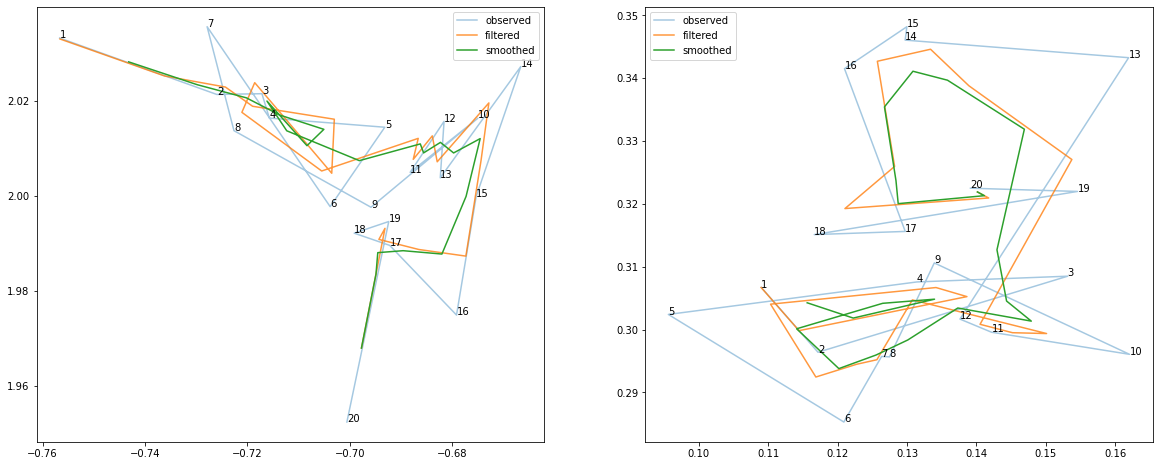

In [64]:
fig, ax = plt.subplots(1, samples, figsize=(20,8))
for i in range(samples):
    ax[i].plot(trajectories[i, :, 0], trajectories[i, :, 1], alpha=0.4, label="observed")
    ax[i].plot(filtered_means[i, :, 0], filtered_means[i, :, 1], alpha=0.8, label="filtered")
    ax[i].plot(smoothed_means[i, :, 0], smoothed_means[i, :, 1], alpha=1, label="smoothed")
    ax[i].legend()
    for j in range(trajectories.shape[1]):
        ax[i].text(trajectories[i, j, 0], trajectories[i, j, 1], str(j+1))
    
    
    

## Introduction to Monte Carlo Methods

### Bayesian HLM

### Gibbs Sampler

### Metropolis Hastings

### Random Walk Metropolis Hastings

### Hamiltonian Monte Carlo 

### No U-Turn Sampler

### MCMC for Structural Time Series

In [115]:
def sts_model():
    local_linear_trend = tfp.sts.LocalLinearTrend(
        level_scale_prior=None,
        slope_scale_prior=None,
        initial_level_prior=None,
        initial_slope_prior=None,
        observed_time_series=None,
        name=None,
    )
    
    day_of_week = tfp.sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=1,
        allow_drift=True,
        drift_scale_prior=None,
        initial_effect_prior=None,
        constrain_mean_effect_to_zero=True,
        observed_time_series=None,
        name=None,
    )
    
    additive_model = tfp.sts.Sum(
        components=[local_linear_trend, day_of_week]
    )
    
    return additive_model

In [98]:
model=sts_model()

In [109]:
y, params = model.prior_sample(100)

In [112]:
for i, param in enumerate(model.parameters):
    print(f"{param.name}: {params[i]}")

observation_noise_scale: 0.03230465203523636
LocalLinearTrend/_level_scale: 3.469969306024723e-05
LocalLinearTrend/_slope_scale: 0.0017195811960846186
Seasonal/_drift_scale: 0.021265100687742233


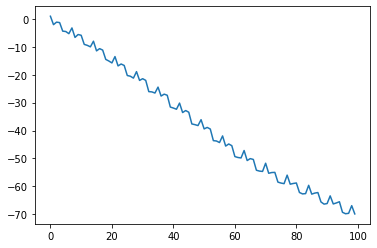

In [100]:
plt.plot(y)